## Chapter 2

- more PyMC3 syntax and variables, 
- `how to model a system` from a Bayesian perspective
- assessing `goodness-of-fit` for your Bayesian model.

In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')

## A little more on PyMC3

### Model Context

In PyMC3, we typically handle all the variables we want in our model within the context of the `Model` object.

In [1]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

Applied log-transform to poisson_param and added transformed poisson_param_log_ to model.


Any variables created within a given `Model`'s context will be automatically assigned to that model. Defining a variable outside of the context of a model, produces an error.

We can continue to work within the context of the same model by using `with` with the name of the model object that we have already created.

In [2]:
with model:
    data_plus_one = data_generator + 1

To create a different model object with the same name as one we have used previously, we need only run the first block of code again.

In [4]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

Applied log-transform to theta and added transformed theta_log_ to model.


We can also define an entirely separate model. Note that we are free to name our models whatever we like, so if we do not want to overwrite an old model we need only make another.

In [5]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

Applied interval-transform to P(A) and added transformed P(A)_interval_ to model.
Applied interval-transform to P(B) and added transformed P(B)_interval_ to model.


#### Notifications about transformations when adding variables to your model.

Transformations purpose is to modify the space that the variable is sampled in (when we get to actually sampling the model) ;  helps with the convergence of our samples to the posterior distribution and serves to improve the results.

### PyMC3 Variables

All PyMC3 variables have an initial value (i.e. `test value`). Using the same variables from before:

In [6]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.693147177890573
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


The `test_value` is used only for the model, as the starting point for sampling if no other start is specified. It will not change as a result of sampling. This initial state can be changed at variable creation by specifying a value for the `testval` parameter.

In [7]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 
                               1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)

Applied log-transform to poisson_param and added transformed poisson_param_log_ to model.

parameter.tag.test_value = 0.49999999904767284


`This can be helpful if you are using a more unstable prior that may require a better starting point.`

#### Types of programming variables

*  `stochastic` are those variables that are not deterministic, i.e., even if you knew all the values of the variables' parameters and components, it would still be random. Included in this category are instances of classes `Poisson`, `DiscreteUniform`, and `Exponential`.

*  `deterministic` are those variables that are not random if the variables' parameters and components were known. This might be confusing at first: a quick mental check is *if I knew all of variable `foo`'s component variables, I could determine what `foo`'s value is.* 

We will detail each below.

#### Initializing Stochastic variables

Initializing a stochastic, or random, variable requires a `name` argument, plus additional parameters that are class specific. For example:
```python
some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)`
```
where 0, 4 are the `DiscreteUniform`-specific lower and upper bound on the random variable.
The `name` attribute is used to retrieve the posterior distribution later in the analysis.

For multivariable problems, rather than an array of stochastic variables, use the `shape` keyword to create a multivariate array of (independent) stochastic variables. 

The `shape` argument also solves the annoying case where you may have many variables $\beta_i, \; i = 1,...,N$ you wish to model. Instead of : 
```python
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)
```
we can instead wrap them into a single variable:
```python
betas = pm.Uniform("betas", 0, 1, shape=N)
```

#### Deterministic variables

We can create a deterministic variable similarly to how we create a stochastic variable. We simply call up the `Deterministic` class in PyMC3 and pass in the function that we desire
```python
deterministic_var = pm.Deterministic("name",
                                     some_function_of_variables)
```
For all purposes, we can treat the object `some_deterministic_var` as a variable and not a Python function. 

Calling `pymc3.Deterministic` is the most obvious way, but not the only way, to create deterministic variables. 

***Elementary operations, like addition, exponentials etc. implicitly create deterministic variables.*** For example, the following returns a deterministic variable:

In [8]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

Applied log-transform to lambda_1 and added transformed lambda_1_log_ to model.
Applied log-transform to lambda_2 and added transformed lambda_2_log_ to model.


If we want a `deterministic` variable to actually be tracked by our sampling, however, we need to define it explicitly as a named `deterministic` variable with the constructor.

The use of the `deterministic` variable was seen in the previous chapter's text-message example.  Recall the model for $\lambda$ looked like: 

$$
\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

And in PyMC3 code:

In [9]:
import numpy as np

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, 
                             lambda_1, 
                             lambda_2)

Clearly, if $\tau, \lambda_1$ and $\lambda_2$ are known, then $\lambda$ is known completely, hence it is a deterministic variable. 

We use the `switch` function here to change from $\lambda_1$ to $\lambda_2$ at the appropriate time. This function is directly from the `theano` package, which we will discuss in the next section.

Inside a `deterministic` variable, the stochastic variables passed in behave like scalars or NumPy arrays (if multivariable). We can do whatever we want with them as long as the dimensions match up in our calculations.

For example, running the following:
```python
def subtract(x, y):
    return x - y

stochastic_1 = pm.Uniform("U_1", 0, 1)
stochastic_2 = pm.Uniform("U_2", 0, 1)

det_1 = pm.Deterministic("Delta", 
                         subtract(stochastic_1, 
                                  stochastic_2))
```
**Note**: The expression that we are making *must* be compatible with `theano` tensors, covered in the next section. 
If you need to do any array-like calculations that would require NumPy functions, make sure you use their equivalents in `theano`.

### Theano

The majority of the heavy lifting done by PyMC3 is taken care of with the `theano` package. 

The notation in `theano` is remarkably similar to NumPy. It also supports many of the familiar computational elements of NumPy.

`theano` builds up a "compute graph" that tracks that you want to perform the `+` operation on the elements `a` and `b`. Only when you `eval()` a `theano` expression does the computation take place (i.e. `theano` is lazy evaluated). Once the compute graph is built, we can perform all kinds of mathematical optimizations (e.g. simplifications), compute gradients via autodiff, compile the entire graph to C to run at machine speed, and also compile it to run on the GPU. 

PyMC3 is basically a collection of `theano` symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients. 

For practical purposes, what this means is that in order to build certain models we sometimes have to use `theano`.

Let's write some PyMC3 code that involves `theano` calculations.

In [10]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

Applied interval-transform to p and added transformed p_interval_ to model.


Here we use `theano`'s `stack()` to combine our two separate variables, `p1` and `p2`, into a vector with $2$ elements. 

The stochastic `categorical` variable does not accept a NumPy array. Stacking combines them into one `theano` variable that we can use as the complementary pair of probabilities for our two categories.

Check out the [documentation](http://deeplearning.net/software/theano/library/).

### Including observations in the Model

At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like "What does my prior distribution of $\lambda_1$ look like?" 

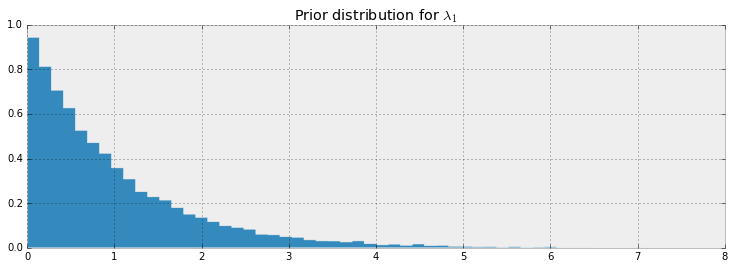

In [11]:
import scipy.stats as stats


samples = lambda_1.random(size=20000)
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.hist(samples, bins=70, 
        density=True, histtype="stepfilled")
ax.title("Prior distribution for $\lambda_1$")
ax.xlim(0, 8);

To frame this in the notation of the first chapter, though this is a slight abuse of notation, we have specified $P(A)$. Our next goal is to include data/evidence/observations $X$ into our model. 

PyMC3 stochastic variables have a keyword argument `observed`. The keyword `observed` has a very simple role: fix the variable's current value to be the given data, typically a NumPy `array` or pandas `DataFrame`. For example:

In [12]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


This is how we include data into our models: initializing a stochastic variable to have a *fixed value*. 

To complete our text message example, we fix the PyMC3 variable `observations` to the observed dataset. 

In [13]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


### More PyMC3 Tricks

#### Protip: Arrays of PyMC3 variables

There is no reason why we cannot store multiple heterogeneous PyMC3 variables in a Numpy array. Just remember to set the `dtype` of the array to `object` upon initialization. For example:

In [ ]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

---